In [1]:
!pip install diffusers
!pip install torchmetrics
!pip install torchmetrics[image]
!pip install torch-fidelity

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 21.0 MB/s eta 0:00:00


In [2]:
# Import packages and libraries

# pytorch
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader

# diffusers
import diffusers

# tools for training and evaluation visualization
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from PIL import Image

In [3]:
# set the training configuration
from dataclasses import dataclass

@dataclass
class TrainConfig:
  img_size = 32
  batch_train = 32
  batch_test = 30
  epochs = 5
  time_step = 1000
  lr = 1e-4
  mask_prob = 0.1
  seed = 512
  gpu_id = 0 # the index of the gpu
  ckpt_dir = 'ckpts'
  result_dir = 'results'

config = TrainConfig()
device = 'cuda:{}'.format(config.gpu_id) if torch.cuda.is_available() else 'cpu'
print(device)
assert config.batch_test % 10 == 0

# create directories to save checkpoints and generation results
if not os.path.exists(config.ckpt_dir):
  os.makedirs(config.ckpt_dir)
if not os.path.exists(config.result_dir):
  os.makedirs(config.result_dir)

cuda:0


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.8MB/s]


Input shape: torch.Size([32, 1, 32, 32])
Labels: tensor([4, 2, 4, 0, 9, 2, 1, 7, 4, 6, 5, 9, 4, 7, 1, 3, 2, 7, 2, 5, 5, 7, 1, 6,
        8, 5, 1, 8, 5, 5, 8, 0])


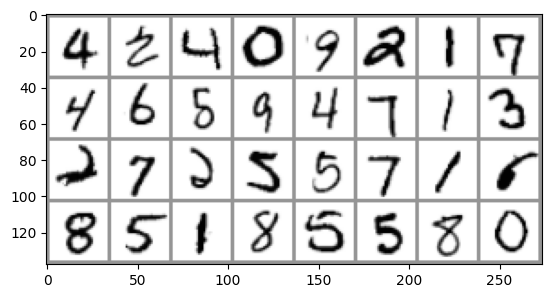

In [4]:
# prepare the MINIST dataset
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(config.img_size),
    torchvision.transforms.Normalize([0.5,], [0.5,])
]) # data preprocessing function

# load the training data
train_dataset = torchvision.datasets.MNIST(root='datasets', train=True,
                    download=True, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=config.batch_train, shuffle=True)

# load the testing data
test_dataset = torchvision.datasets.MNIST(root='datasets', train=False,
                    download=True, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=config.batch_train, shuffle=False)

# sample and display one batch of digit images
img_real, label = next(iter(train_dataloader))
print("Input shape:", img_real.shape)
print("Labels:", label)
plt.imshow(torchvision.utils.make_grid(img_real)[0], cmap="Greys")

In [5]:
# define the denoising model with class labels as condition
class Model(nn.Module):
  def __init__(self, num_classes=10, cond_embedding_size=4):
    super().__init__()

    # The layer to map the class condition to a feature vector
    self.cond_embedding = nn.Embedding(num_classes, cond_embedding_size)

    # The model to remove noise
    self.model = diffusers.UNet2DModel(
        sample_size=config.img_size,
        in_channels=1+cond_embedding_size,
        out_channels=1,
        layers_per_block=2,
        block_out_channels=(128,128,256,512),
        down_block_types=(
            "DownBlock2D",
            "DownBlock2D",
            "AttnDownBlock2D",
            "DownBlock2D",
        ),
        up_block_types=(
            "UpBlock2D",
            "AttnUpBlock2D",
            "UpBlock2D",
            "UpBlock2D",
        ),
    )

  def forward(self, img_noisy, step, class_label, mask=None):
    b, c, h, w = img_noisy.shape

    # Map the class label to feature vector and pad it to match the size of the target image
    if mask is None:
      mask = torch.ones(img_noisy.shape[0], device=img_noisy.device)
    cond = self.cond_embedding(class_label) * mask.unsqueeze(1)
    cond = cond.view(cond.shape[0], cond.shape[1], 1, 1).repeat(1,1, w, h)

    # concatenate the condition feature and input noisy image
    x = torch.cat([img_noisy, cond], dim=1)
    x = self.model(x, step)

    return x['sample']

model = Model().to(device)

In [6]:
# define the scheduler, optimizer, loss function
noise_scheduler = diffusers.DDPMScheduler(num_train_timesteps=config.time_step)
optimizer = torch.optim.AdamW(model.parameters(),lr=config.lr)

loss_fn = nn.MSELoss()

In [7]:
# define the training loop
def train(config, model, noise_scheduler, optimizer, train_dataloader):

  losses = []
  epoch_losses = []
  mask_prob = config.mask_prob
  # mask_prob = 0
  for epoch in range(config.epochs):
    pbar = tqdm(train_dataloader)

    for img, label in pbar:
      img_clean = img.to(device)
      label = label.to(device)

      '''
      TODO:
      1. create a random Gaussian noise (hint, using torch.randn or torch.randn_like) which has the same size as image (B, C, H, W)
      2. randomly pick timesteps (hint, using torch.randint)
      3. add the noise to the clean image using noise_scheduler.add_noise
      4. randomly create a image mask to indicate whether set the condition to be empty
      5. predict the noise added to the clean image using model and compute loss
      '''

      noise = torch.randn_like(img_clean)

      timesteps = torch.randint(0, config.time_step, (img_clean.shape[0],), device=device).long()

      img_noisy = noise_scheduler.add_noise(img_clean, noise, timesteps)

      mask = (torch.rand(img_clean.shape[0], device=device) > mask_prob).float()

      noise_pred = model(img_noisy, timesteps, label, mask)
      loss = loss_fn(noise_pred, noise)

      # update the model's parameters
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      losses.append(loss.item())

      pbar.update(1)
      pbar.set_postfix_str('Epoch [{}/{}] loss {:.5f}'.format(epoch+1, config.epochs, np.mean(losses[-100:])))

    epoch_losses.append(np.mean(losses[-len(train_dataloader):]))

    state_dict = {
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }
    torch.save(state_dict, os.path.join(config.ckpt_dir, '{}.pth'.format(epoch+1)))

  return losses, epoch_losses

In [8]:
# define the sampling function
@torch.no_grad()
def sample(config, model, noise_scheduler, seed=512, device='cpu'):
  torch.manual_seed(seed)
  img = torch.randn((int(config.batch_test//10*10),1,config.img_size,config.img_size)).to(device)
  label = torch.arange(10).to(device)
  label = torch.cat([label for _ in range(int(config.batch_test//10))])

  '''
  TODO:
  Create a for-loop to denoise img.
  You may need following two variable/function
  noise_scheduler.timesteps
  noise_scheduler.step
  '''

  for t in tqdm(noise_scheduler.timesteps):
    noise_pred = model(img, t, label, mask=None)
    img = noise_scheduler.step(noise_pred, t, img).prev_sample

  return img

@torch.no_grad()
def sample_cfg(config, model, noise_scheduler, cfg_scale=7.5, seed=512, device='cpu'):
  torch.manual_seed(seed)
  img = torch.randn((int(config.batch_test//10*10),1,config.img_size,config.img_size)).to(device)
  label = torch.arange(10).to(device)
  label = torch.cat([label for _ in range(int(config.batch_test//10))])
  labels = torch.cat([label, label], dim=0)
  mask0 = torch.zeros(img.shape[0], device=device) # empty condition
  mask1 = torch.ones(img.shape[0], device=device)

  '''
  TODO:
  Create a for-loop to denoise img with Classifier Free Guidance.
  Hint: during the inference, conduct two prediction, pred_uncond with empty condition (use mask0), pred_cond with number condition (use mask1)
  The final prediction is the extrapolation between the above two predictions
  '''

  for t in tqdm(noise_scheduler.timesteps):
    img_input = torch.cat([img, img], dim=0)

    noise_pred_uncond = model(img, t, label, mask=mask0)

    noise_pred_cond = model(img, t, label, mask=mask1)

    noise_pred = noise_pred_uncond + cfg_scale * (noise_pred_cond - noise_pred_uncond)

    img = noise_scheduler.step(noise_pred, t, img).prev_sample

  return img

# Visualize intermediate denoising steps
@torch.no_grad()
def sample_with_intermediate_steps(config, model, noise_scheduler, cfg_scale=7.5, seed=512, device='cpu', num_steps_to_save=10):
  torch.manual_seed(seed)
  img = torch.randn((10, 1, config.img_size, config.img_size)).to(device)
  label = torch.arange(10).to(device)
  mask0 = torch.zeros(img.shape[0], device=device)
  mask1 = torch.ones(img.shape[0], device=device)

  intermediate_images = []
  total_steps = len(noise_scheduler.timesteps)
  save_interval = max(1, total_steps // num_steps_to_save)

  for idx, t in enumerate(tqdm(noise_scheduler.timesteps)):
    noise_pred_uncond = model(img, t, label, mask=mask0)
    noise_pred_cond = model(img, t, label, mask=mask1)
    noise_pred = noise_pred_uncond + cfg_scale * (noise_pred_cond - noise_pred_uncond)
    img = noise_scheduler.step(noise_pred, t, img).prev_sample

    if idx % save_interval == 0 or idx == total_steps - 1:
      intermediate_images.append(img.clone())

  return img, intermediate_images

In [9]:
losses, epoch_losses = train(config, model, noise_scheduler, optimizer, train_dataloader)


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

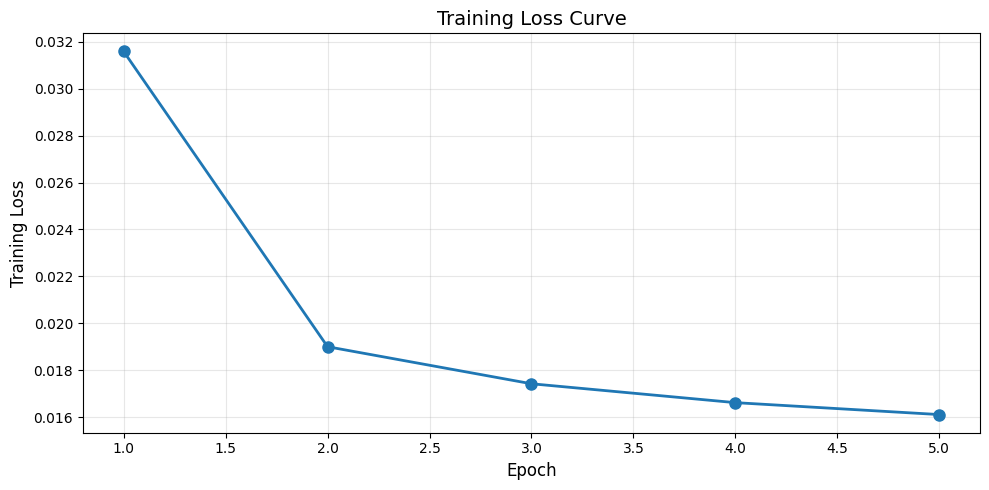

In [10]:
# Plot training loss curve
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(epoch_losses)+1), epoch_losses, marker='o', linewidth=2, markersize=8)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Training Loss', fontsize=12)
plt.title('Training Loss Curve', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(config.result_dir, 'training_loss.png'), dpi=300, bbox_inches='tight')
plt.show()


In [11]:
# evaluate the performance of the trained mode
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore

def evaluate(config, model, noise_scheduler, device):
  # initialize the metrics
  metric_fid = FrechetInceptionDistance(normalize=True).to(device)
  metric_is = InceptionScore().to(device)

  with torch.no_grad():
    # generate digit images of 0-9
    model.eval()
    img_generate = sample(config, model, noise_scheduler, seed=config.seed, device=device)

  # calculate FID and IS
  metric_fid.update(img_real.repeat(1,3,1,1).to(device)*127.5+127.5, real=True)
  metric_fid.update(img_generate.repeat(1,3,1,1)*127.5+127.5, real=False)
  print(f"FID: {float(metric_fid.compute())}")

  metric_is.update((img_generate.repeat(1,3,1,1)*127.5+127.5).to(torch.uint8))
  print(f"IS: mean {float(metric_is.compute()[0].item())} std  {float(metric_is.compute()[1].item())}")

  # display and save the generation reulsts
  fig, ax = plt.subplots(1, 1, figsize=(12, 12))
  ax.imshow(torchvision.utils.make_grid(img_generate.detach().cpu().clip(-1, 1), nrow=config.batch_test//10)[0], cmap="Greys")
  fig.savefig(os.path.join(config.result_dir, 'seed_{}.png'.format(config.seed)), bbox_inches='tight')

def evaluate_cfg(config, model, noise_scheduler, device):
  # initialize the metrics
  metric_fid = FrechetInceptionDistance(normalize=True).to(device)
  metric_is = InceptionScore().to(device)

  cfg_scales = [7.5, 5.5, 3.5, 1.5, 0.5]
  for cfg_scale in cfg_scales:
    print('Results with cfg scale of {}'.format(cfg_scale))
    with torch.no_grad():
      # generate digit images of 0-9
      model.eval()
      img_generate = sample_cfg(config, model, noise_scheduler, cfg_scale=cfg_scale, seed=config.seed, device=device)

    # calculate FID and IS
    metric_fid.update(img_real.repeat(1,3,1,1).to(device)*127.5+127.5, real=True)
    metric_fid.update(img_generate.repeat(1,3,1,1)*127.5+127.5, real=False)
    print(f"FID: {float(metric_fid.compute())}")

    metric_is.update((img_generate.repeat(1,3,1,1)*127.5+127.5).to(torch.uint8))
    print(f"IS: mean {float(metric_is.compute()[0].item())} std  {float(metric_is.compute()[1].item())}")

    # display and save the generation reulsts
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    ax.imshow(torchvision.utils.make_grid(img_generate.detach().cpu().clip(-1, 1), nrow=10)[0], cmap="Greys")
    fig.savefig(os.path.join(config.result_dir, 'cfg_{}.png'.format(cfg_scale)), bbox_inches='tight')

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 405MB/s]
/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


Results with cfg scale of 7.5


  0%|          | 0/1000 [00:00<?, ?it/s]

FID: 329.2542724609375
IS: mean 1.3532249927520752 std  0.09193015843629837
Results with cfg scale of 5.5


  0%|          | 0/1000 [00:00<?, ?it/s]

FID: 319.5367126464844
IS: mean 1.507929801940918 std  0.12674202024936676
Results with cfg scale of 3.5


  0%|          | 0/1000 [00:00<?, ?it/s]

FID: 315.6424865722656
IS: mean 1.576309084892273 std  0.08316675573587418
Results with cfg scale of 1.5


  0%|          | 0/1000 [00:00<?, ?it/s]

FID: 320.6795654296875
IS: mean 1.6119428873062134 std  0.08751054853200912
Results with cfg scale of 0.5


  0%|          | 0/1000 [00:00<?, ?it/s]

FID: 329.253173828125
IS: mean 1.6375923156738281 std  0.10431912541389465


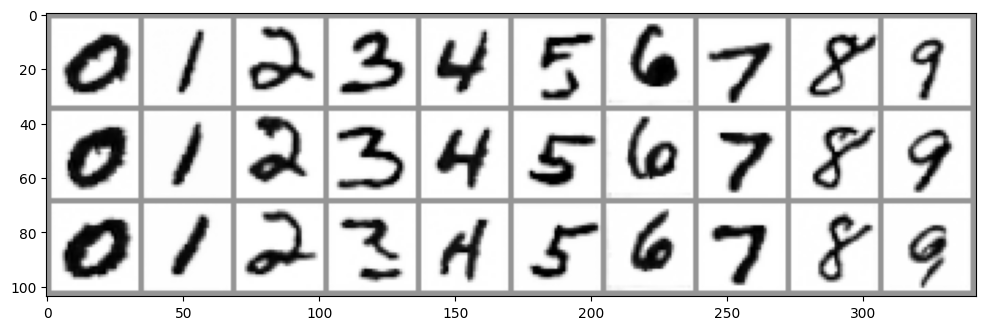

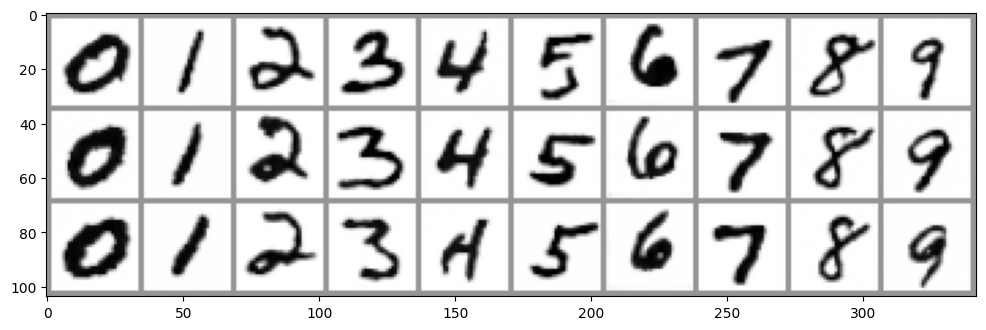

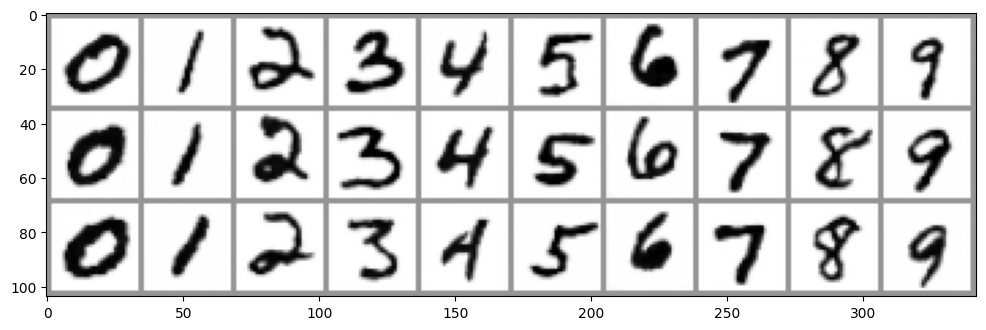

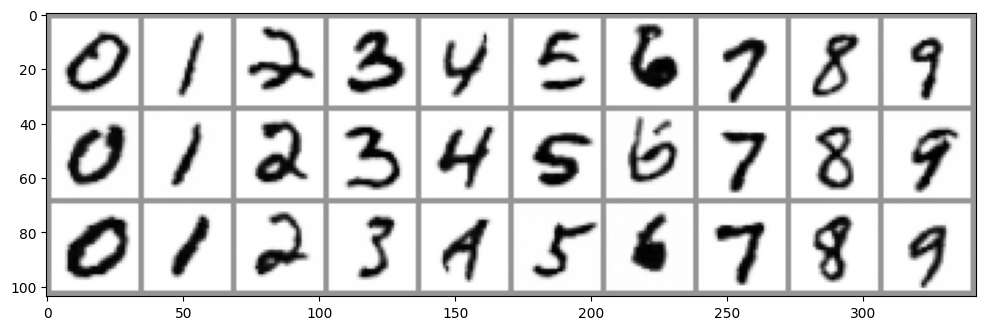

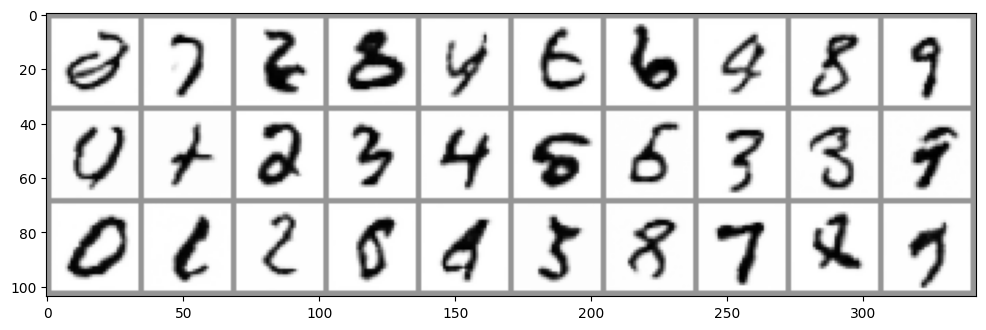

In [12]:
# evaluate_cfg(config, model, noise_scheduler, device)
evaluate_cfg(config, model, noise_scheduler, device)

  0%|          | 0/1000 [00:00<?, ?it/s]

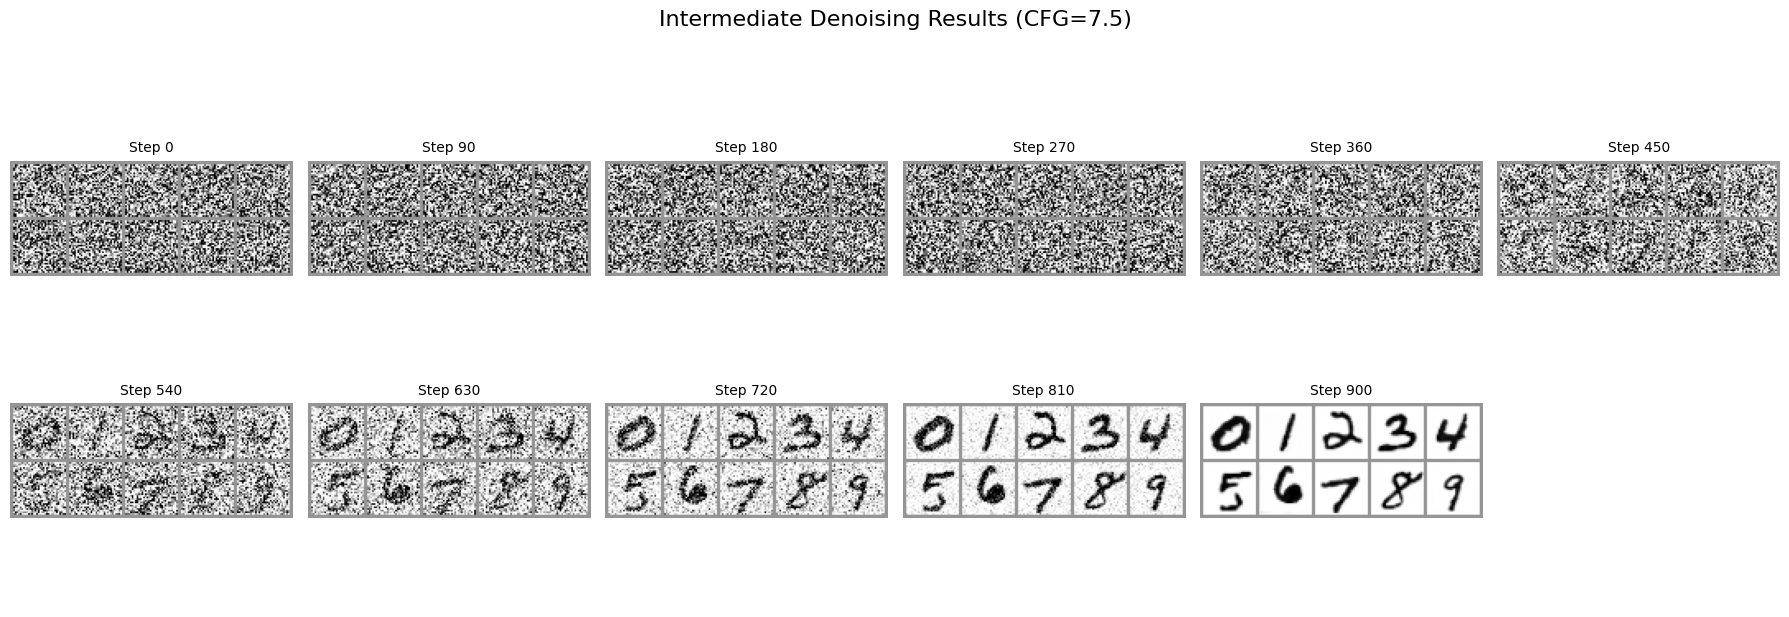

In [13]:
# Visualize intermediate denoising process
final_img, intermediate_imgs = sample_with_intermediate_steps(config, model, noise_scheduler, cfg_scale=7.5, seed=512, device=device, num_steps_to_save=10)

fig, axes = plt.subplots(2, 6, figsize=(18, 6))
fig.suptitle('Intermediate Denoising Results (CFG=7.5)', fontsize=16, y=1.02)

for idx, ax in enumerate(axes.flat):
    if idx < len(intermediate_imgs):
        img_grid = torchvision.utils.make_grid(intermediate_imgs[idx].detach().cpu().clip(-1, 1), nrow=5)[0]
        ax.imshow(img_grid, cmap='Greys')
        step_num = idx * (1000 // len(intermediate_imgs))
        ax.set_title(f'Step {step_num}', fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(config.result_dir, 'intermediate_denoising.png'), dpi=300, bbox_inches='tight')
plt.show()